In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from matplotlib import animation, rc
from IPython.display import HTML

# Background

In this notebook we will explore wave packets and see how free particles evolve over time.

We will be using a result that's outside the scope of this class, namely the conversion between position- and momentum-space representation of the wavefunction.

$$\Psi(x, t) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}\Phi(k, t)e^{ikx}dk $$

$$\Phi(k, t) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}\Psi(x, t)e^{-ikx}dx $$

As a reminder, $k=p/\hbar$. With this momentum variable, we can write the (kinetic) energy as:
$$E_k=\frac{\hbar^2k^2}{2m}$$
And the angular frequency as
$$\omega = \frac{E_k}{\hbar} = \frac{\hbar k^2}{2m}$$
which will be useful for time evolution.

## Quick word on FFTs
Fast Fourier Transforms (FFTs) are super useful, but are necessarily implemented on descrete data. The transformations above are continuous integrals, so we need to do a little work to get the `numpy.fft` module to do what we want. A wrote a memo on doing this long ago:
[FFT Memo](https://www.dropbox.com/s/fwh5elnx6daz4l8/FT_Memo.pdf)

I'm not going to go into the details, just know there are bits to make sure the units work.

In [2]:
def psi_k_from_x(psix, xarr):
    dx = np.mean(np.diff(xarr))
    psik = dx / np.sqrt(2 * np.pi) * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(psix)))
    karr = 2 * np.pi * (np.arange(len(xarr)) - len(xarr) / 2) / (len(xarr) * dx)
    return psik, karr

def psi_x_from_k(psik, karr):
    dk = np.mean(np.diff(karr))
    psix = len(karr) * dk / np.sqrt(2 * np.pi) * np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(psik)))
    xarr = 2 * np.pi * (np.arange(len(karr)) - len(karr) / 2) / (len(karr) * dk)
    return psix, xarr

def time_evolve_psi_k(psik, karr, tarr, m=const.m_e):
    oarr = const.hbar * karr**2 / (2 * m)  # omega array
    # Broadcast and use 0th axis for time to accommodate fft in functions above
    psikt = psik[np.newaxis, :] * np.exp(-1j*oarr[np.newaxis, :] * tarr[:, np.newaxis])
    return psikt

Start with a Gaussian wave. Let's compare two widths.

In [3]:
# Axis parameters
xrange = [-.5, .5]  # Within 1m
dx = 0.005
xarr = np.arange(xrange[0], xrange[1], dx)

# Wavefunction parameters
x0_1 = 0
x0_2 = 0
sigma_1 = 0.05
sigma_2 = 0.1

psix1 = np.exp(-(xarr - x0_1)**2 / (2 * sigma_1**2)) / np.sqrt(sigma_1**2 * 2 * np.pi)
psix2 = np.exp(-(xarr - x0_2)**2 / (2 * sigma_2**2)) / np.sqrt(sigma_2**2 * 2 * np.pi)
psik1, karr = psi_k_from_x(psix1, xarr)
psik2, karr = psi_k_from_x(psix2, xarr)

<IPython.core.display.Javascript object>


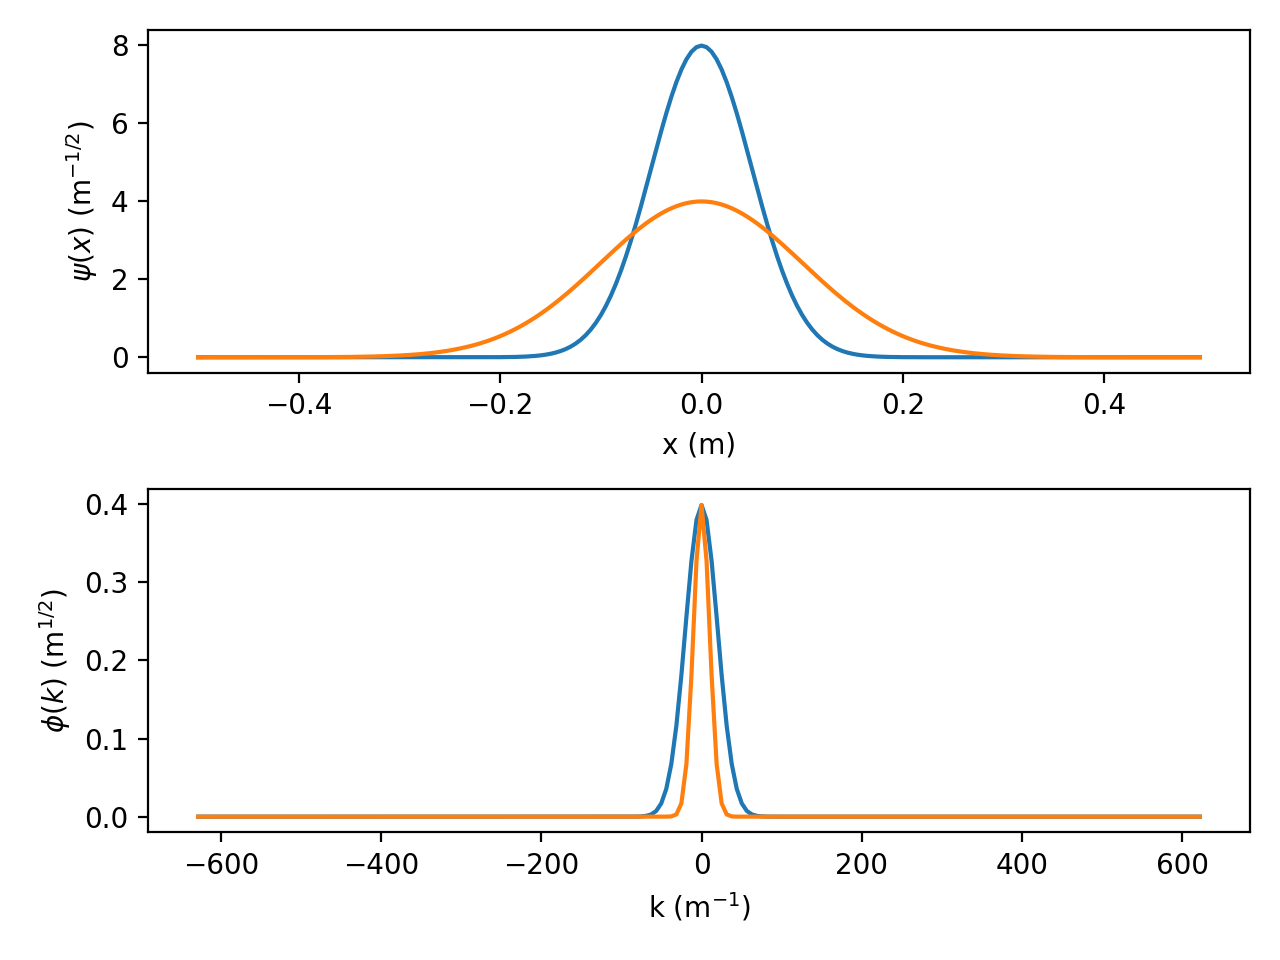

In [4]:
fig = plt.figure()
ax1 = plt.subplot(211)
plt.plot(xarr, np.abs(psix1), label='WF 1')
plt.plot(xarr, np.abs(psix2), label='WF 2')
plt.xlabel('x (m)')
plt.ylabel('$\psi(x)$ (m$^{-1/2}$)')
plt.subplot(212)
plt.plot(karr, np.abs(psik1), label='WF 1')
plt.plot(karr, np.abs(psik2), label='WF 2')
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$\phi(k)$ (m$^{1/2}$)')
plt.tight_layout()

Above we see a wider (gaussian) position wavefunction results in a more narrow momentum wavefunction, and vice versa. In fact we have seen this before - it's the Heisenberg uncertainty principle.
$$\Delta x \Delta k \le \frac{1}{2}$$

Let's look at what happens when our position wavefunction is offset from zero.

In [5]:
# Wavefunction parameters
x0_1 = 0
x0_2 = .1
sigma_1 = 0.05
sigma_2 = 0.05

psix1 = np.exp(-(xarr - x0_1)**2 / (2 * sigma_1**2)) / np.sqrt(sigma_1**2 * 2 * np.pi)
psix2 = np.exp(-(xarr - x0_2)**2 / (2 * sigma_2**2)) / np.sqrt(sigma_2**2 * 2 * np.pi)
psik1, karr = psi_k_from_x(psix1, xarr)
psik2, karr = psi_k_from_x(psix2, xarr)

<IPython.core.display.Javascript object>


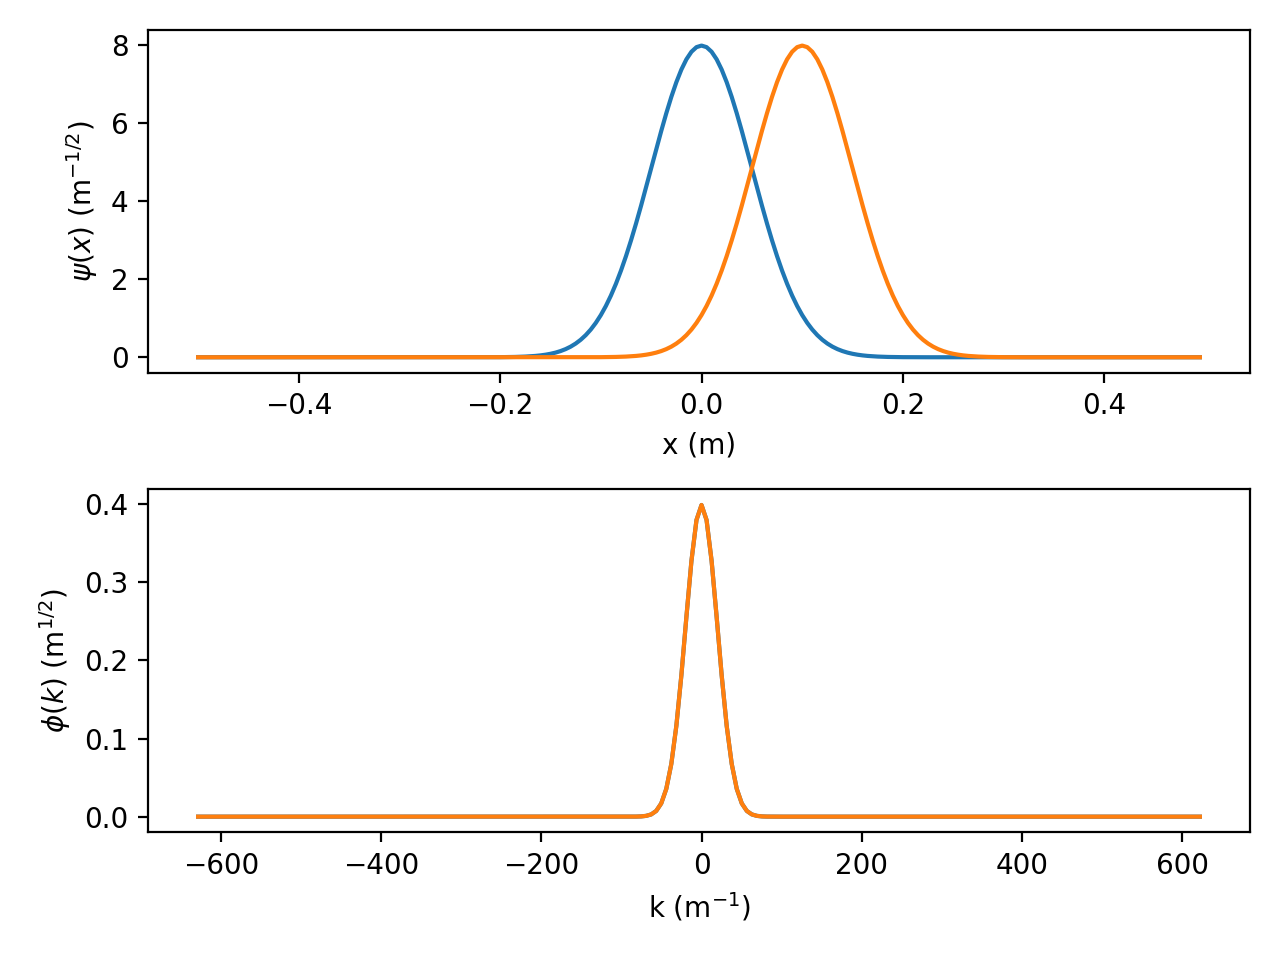

In [6]:
fig = plt.figure()
ax1 = plt.subplot(211)
plt.plot(xarr, np.abs(psix1), label='WF 1')
plt.plot(xarr, np.abs(psix2), label='WF 2')
plt.xlabel('x (m)')
plt.ylabel('$\psi(x)$ (m$^{-1/2}$)')
plt.subplot(212)
plt.plot(karr, np.abs(psik1), label='WF 1')
plt.plot(karr, np.abs(psik2), label='WF 2')
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$\phi(k)$ (m$^{1/2}$)')
plt.tight_layout()

The momentum wavefunctions are right on top of each other! Indeed, we didn't "push" the wavefunction, so it is still centered around 0. But what happens when we look at the real/imagingary parts?

<IPython.core.display.Javascript object>


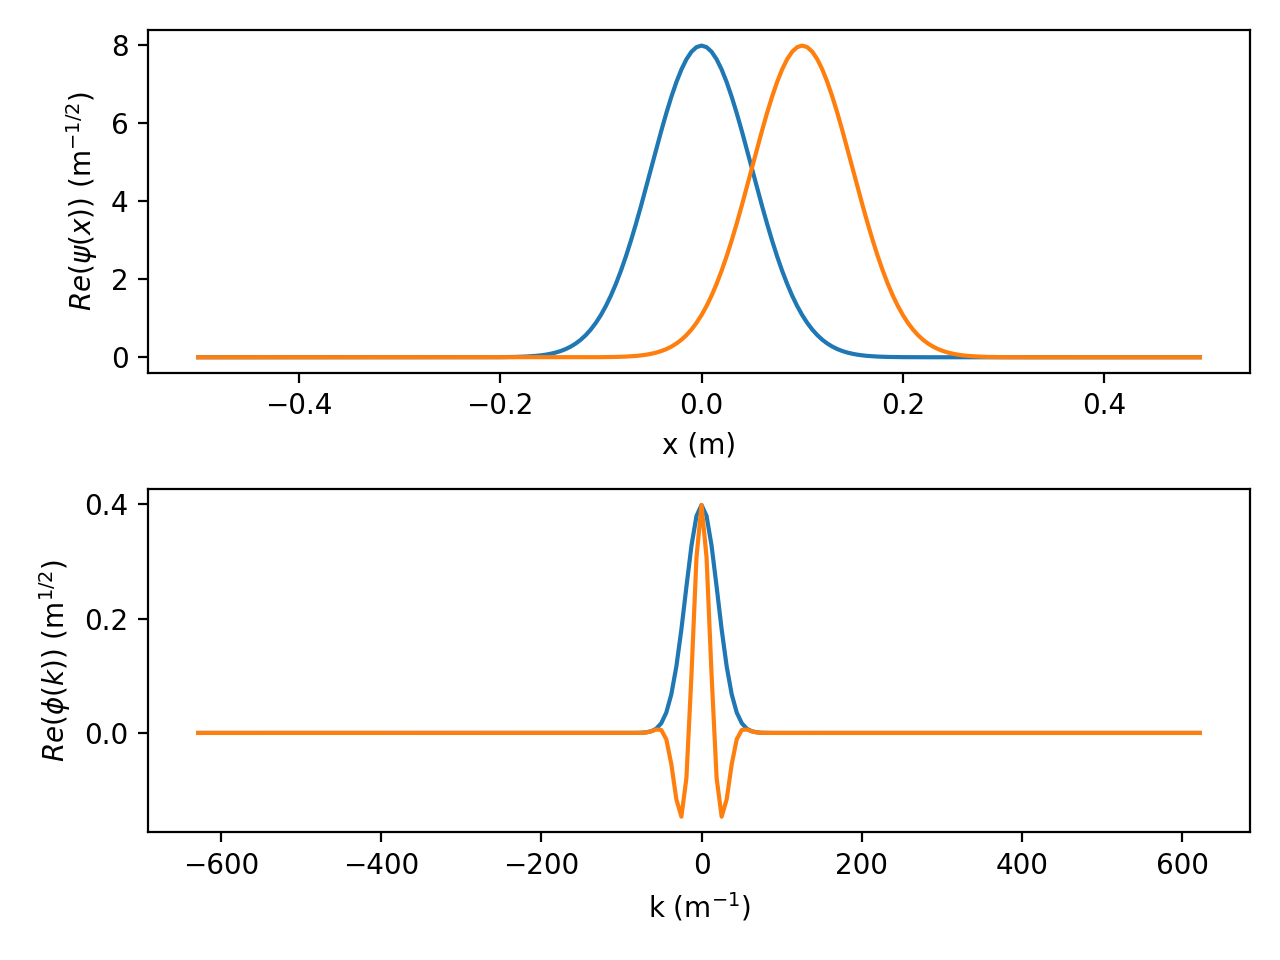

In [8]:
fig = plt.figure()
ax1 = plt.subplot(211)
plt.plot(xarr, np.real(psix1), label='WF 1')
plt.plot(xarr, np.real(psix2), label='WF 2')
plt.xlabel('x (m)')
plt.ylabel('$Re(\psi(x))$ (m$^{-1/2}$)')
plt.subplot(212)
plt.plot(karr, np.real(psik1), label='WF 1')
plt.plot(karr, np.real(psik2), label='WF 2')
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$Re(\phi(k))$ (m$^{1/2}$)')
plt.tight_layout()

Moving the position wavefunction over resulted in the momentum wavefunction oscillating in the complex plane.

Ok, now let's look at what happens as time progresses.

In [9]:
tarr = np.arange(0, 70, 1)

# Wavefunction parameters
x0 = 0
sigma = 0.05

psix = np.exp(-(xarr - x0)**2 / (2 * sigma**2)) / np.sqrt(sigma**2 * 2 * np.pi)
psik, karr = psi_k_from_x(psix, xarr)
psikt = time_evolve_psi_k(psik, karr, tarr)
psixt, _ = psi_x_from_k(psikt, karr)

<IPython.core.display.Javascript object>


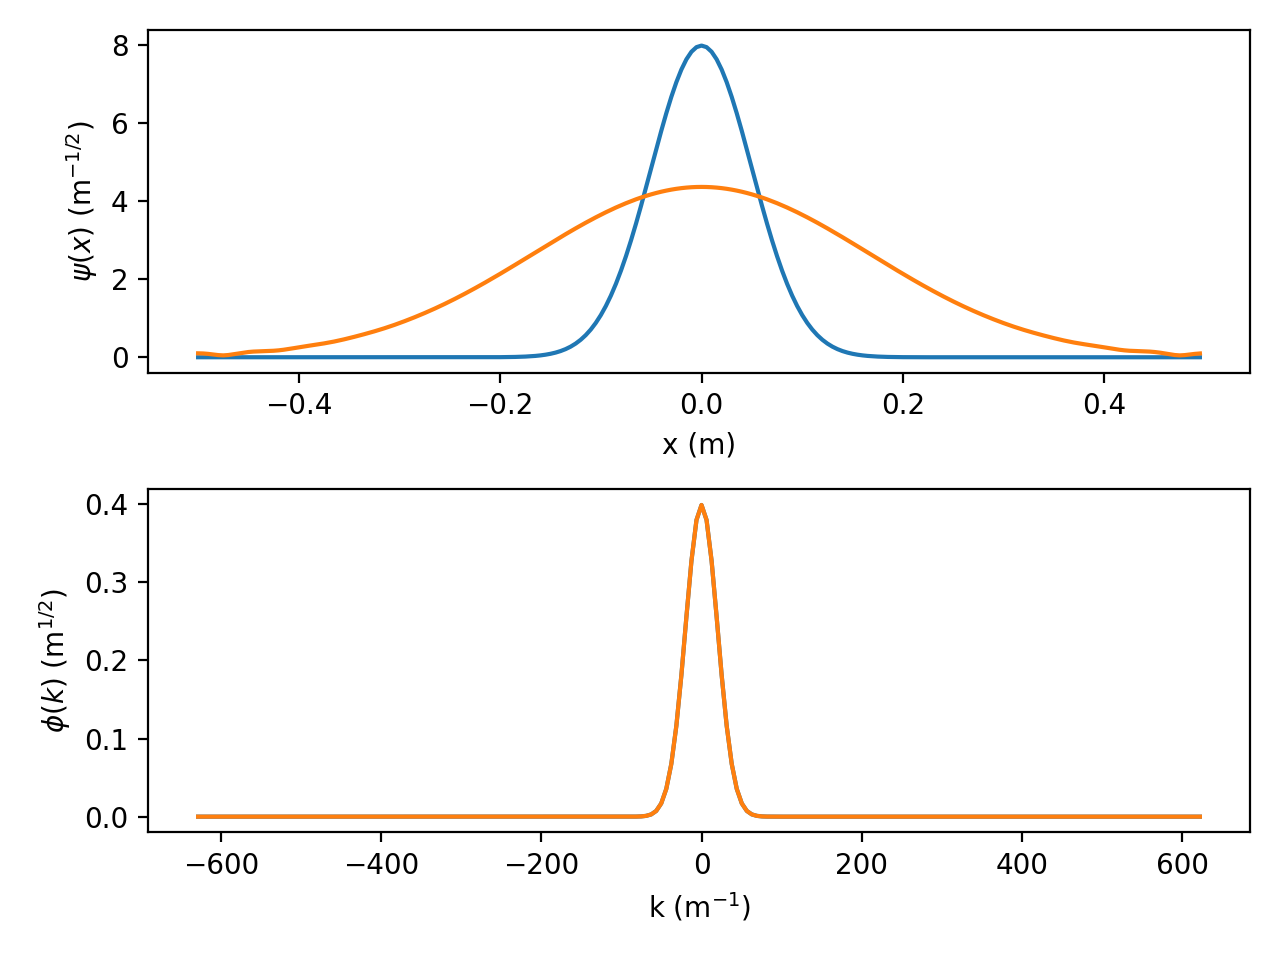

In [10]:
fig = plt.figure()
ax1 = plt.subplot(211)
plt.plot(xarr, np.abs(psixt[0, :]), label='t0')
plt.plot(xarr, np.abs(psixt[-1, :]), label='t1')
plt.xlabel('x (m)')
plt.ylabel('$\psi(x)$ (m$^{-1/2}$)')
plt.subplot(212)
plt.plot(karr, np.abs(psikt[0, :]), label='t0')
plt.plot(karr, np.abs(psikt[-1, :]), label='t1')
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$\phi(k)$ (m$^{1/2}$)')
plt.tight_layout()

The uncertainty in momemtum is causing the wavepacket to spread out. One interesting thing to note is that the probability distribution of the momentum is not changing, but the position is. So even though we started with a pair of gaussians that met the mimimum uncertainty, we no longer have that once we let them evolve.


Let's animate it.

<IPython.core.display.Javascript object>


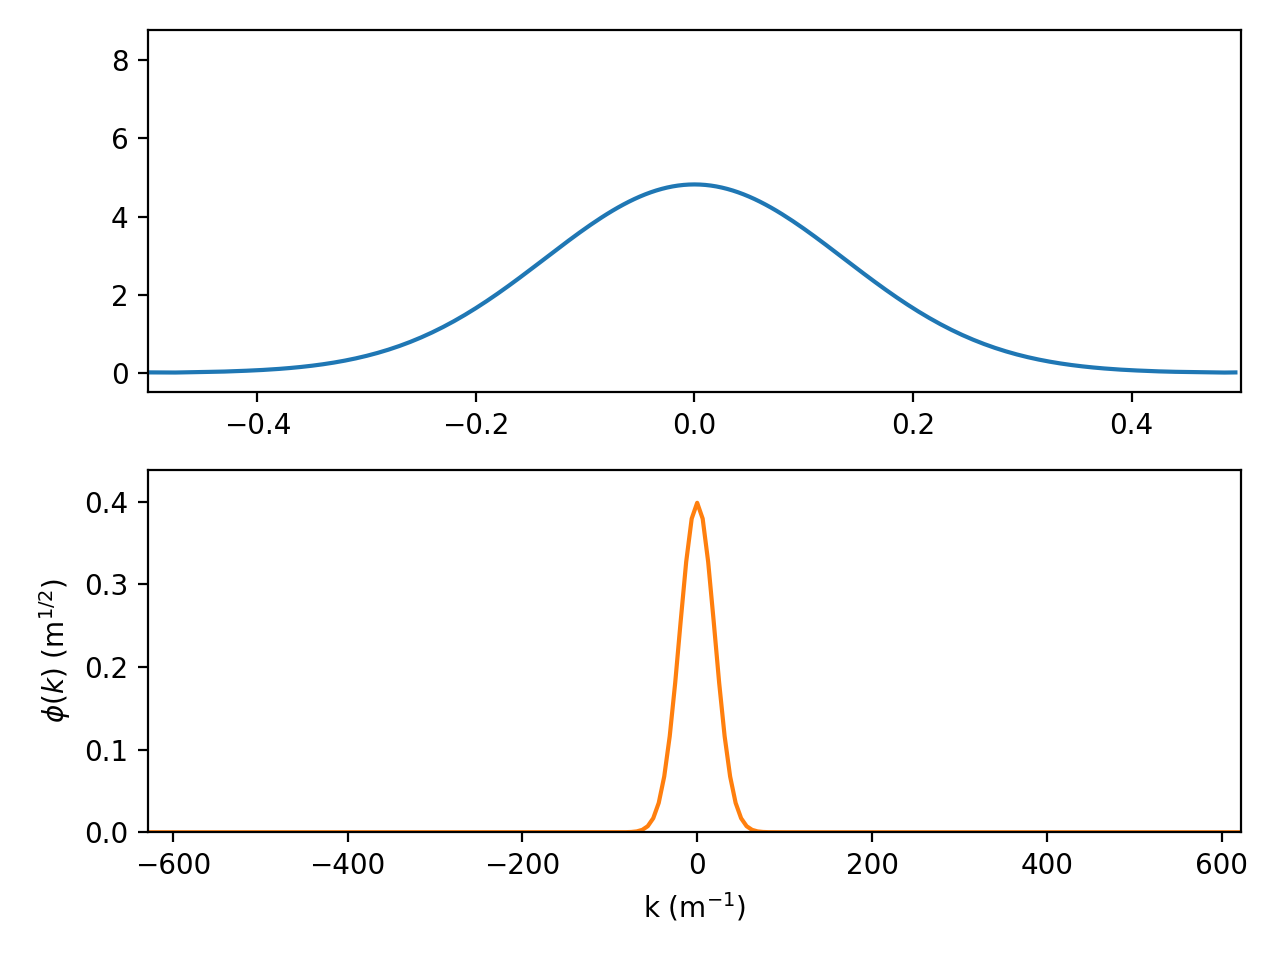

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1);
lines = []

ax[0].set_xlim(xrange)
ax[0].set_ylim([-.5, 1.1 * np.max(np.abs(psixt))])
lines.append(ax[0].plot([], [], label='Abs($\Psi$)')[0]);
plt.xlabel('x (m)')
plt.ylabel('$\psi(x)$ (m$^{-1/2}$)')
ax[1].set_xlim([karr.min(), karr.max()])
ax[1].set_ylim([0, 1.1 * np.max(np.abs(psikt))])
lines.append(ax[1].plot([], [], 'C1', label='Abs($\Phi$)')[0]);
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$\phi(k)$ (m$^{1/2}$)')
plt.tight_layout()
    
def init():
    for line in lines:
        line.set_data([], [])

def animate(i):
    lines[0].set_data(xarr, np.abs(psixt[i, :]))
    lines[1].set_data(karr, np.abs(psikt[i, :]))

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(tarr), interval=100, blit=True)
# HTML(anim.to_html5_video())

Now let's see what happens when we give the momentum a little "kick" by centering it away from zero.

In [12]:
# Momentum wavefunction parameters
k0 = 100
sigma = 20

psik = np.exp(-(karr - k0)**2 / (2 * sigma**2)) / np.sqrt(sigma**2 * 2 * np.pi)
psikt = time_evolve_psi_k(psik, karr, tarr)
psixt, xarr = psi_x_from_k(psikt, karr)

<IPython.core.display.Javascript object>


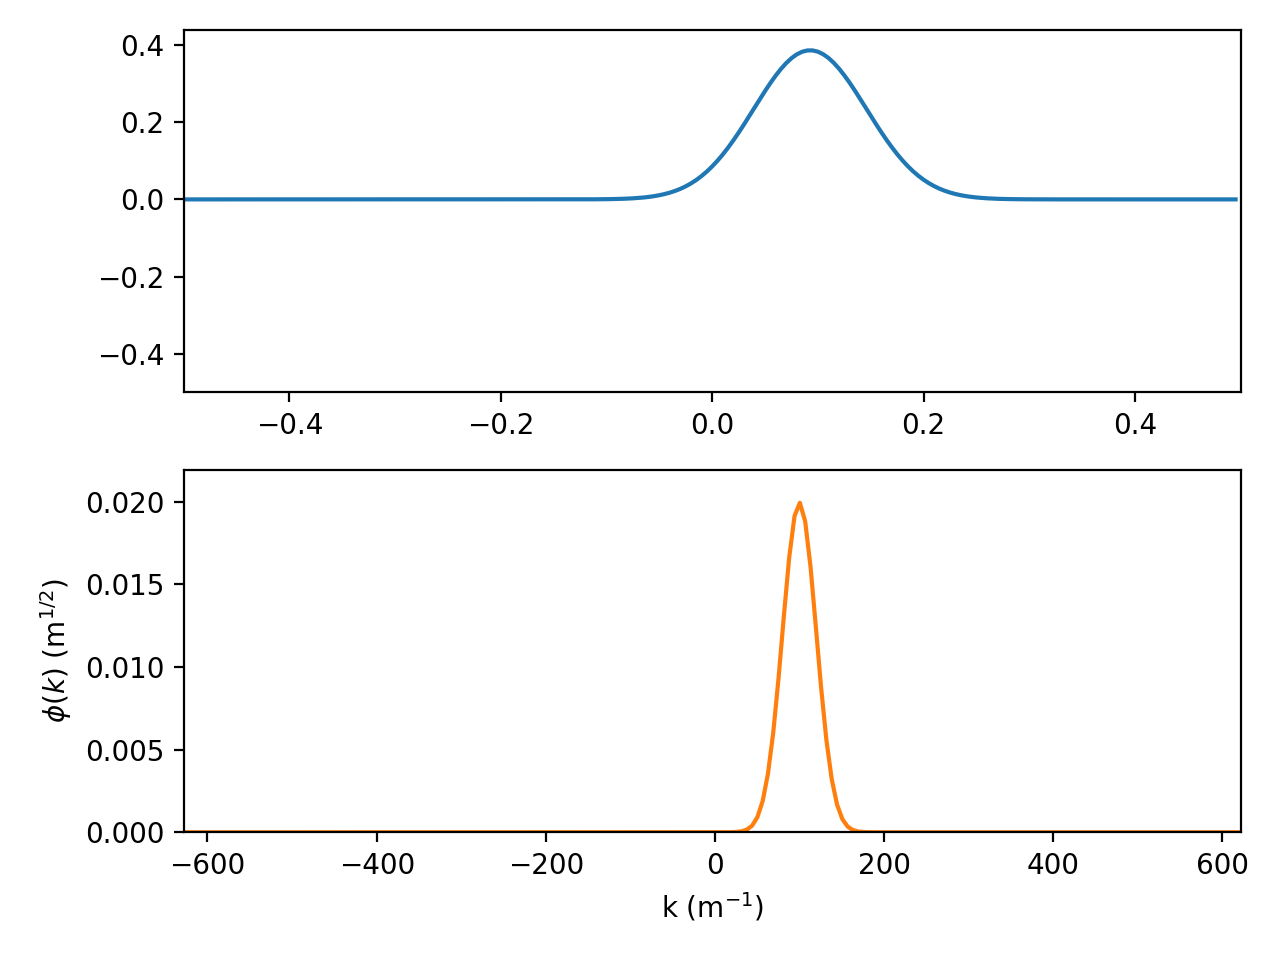

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1);
lines = []

ax[0].set_xlim(xrange)
ax[0].set_ylim([-.5, 1.1 * np.max(np.abs(psixt))])
lines.append(ax[0].plot([], [], label='Abs($\Psi$)')[0]);
plt.xlabel('x (m)')
plt.ylabel('$\psi(x)$ (m$^{-1/2}$)')
ax[1].set_xlim([karr.min(), karr.max()])
ax[1].set_ylim([0, 1.1 * np.max(np.abs(psikt))])
lines.append(ax[1].plot([], [], 'C1', label='Abs($\Phi$)')[0]);
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$\phi(k)$ (m$^{1/2}$)')
plt.tight_layout()
    
def init():
    for line in lines:
        line.set_data([], [])

def animate(i):
    lines[0].set_data(xarr, np.abs(psixt[i, :]))
    lines[1].set_data(karr, np.abs(psikt[i, :]))

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(tarr), interval=100, blit=True)
# HTML(anim.to_html5_video())

Pretty cool, huh? We gave the wavefunction a nonzero momentum, and sure enough we see it moving along. It's still spreading out due to the uncertain momentum. And you also see it looping on the screen - that part's not real, but just a consequence of how we compute the wavefunction using FFTs.

Ok, let's try one more thing for this notebook. What happens when we put two wavepackets right next to each other? Think about this as the part of the wavefunction that passes through two slits.

In [14]:
xrange = [-1.5, 1.5]
xarr = np.arange(xrange[0], xrange[1], dx)

x0_1 = 0.1
x0_2 = -0.1
sigma_1 = 0.02
sigma_2 = 0.02

psix1 = np.exp(-(xarr - x0_1)**2 / (2 * sigma_1**2)) / np.sqrt(sigma_1**2 * 2 * np.pi)
psix2 = np.exp(-(xarr - x0_2)**2 / (2 * sigma_2**2)) / np.sqrt(sigma_2**2 * 2 * np.pi)
# The following line is not quite right, but it's close enough for our purposes.
psix = 1 / np.sqrt(2) * (psix1 + psix2)

tarr = np.arange(0, 70, 1)

psik, karr = psi_k_from_x(psix, xarr)
psikt = time_evolve_psi_k(psik, karr, tarr)
psixt, _ = psi_x_from_k(psikt, karr)

<IPython.core.display.Javascript object>


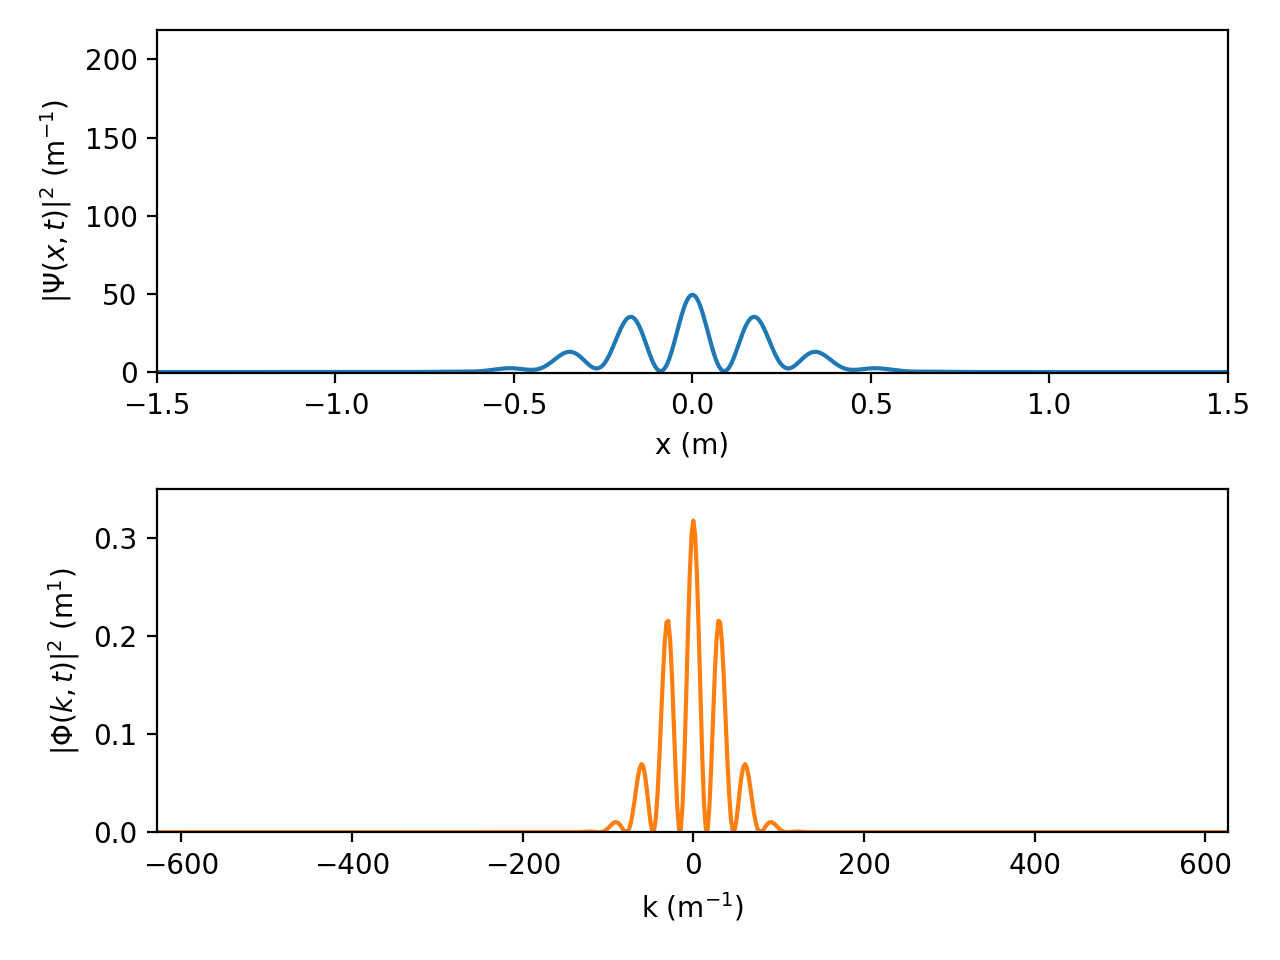

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1);
lines = []

ax[0].set_xlim(xrange)
ax[0].set_ylim([-.5, 1.1 * np.max(np.abs(psixt)**2)])
lines.append(ax[0].plot([], [], label='$|\Psi|^2$)')[0]);
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('$|\Psi(x, t)|^2$ (m$^{-1}$)')
ax[1].set_xlim([karr.min(), karr.max()])
ax[1].set_ylim([0, 1.1 * np.max(np.abs(psikt)**2)])
lines.append(ax[1].plot([], [], 'C1', label='$|\Phi|^2$)')[0]);
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$|\Phi(k, t)|^2$ (m$^{1}$)')
plt.tight_layout()
    
def init():
    for line in lines:
        line.set_data([], [])

def animate(i):
    lines[0].set_data(xarr, np.abs(psixt[i, :])**2)
    lines[1].set_data(karr, np.abs(psikt[i, :])**2)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(tarr), interval=100, blit=True)
# HTML(anim.to_html5_video())
# anim.save('im.mp4')

In [17]:
xrange = [-1.5, 1.5]
xarr = np.arange(xrange[0], xrange[1], dx)

x0_1 = 0.1
x0_2 = -0.1
sigma_1 = 0.02
sigma_2 = 0.02

psix = np.zeros(len(xarr))
psix[np.abs(xarr - x0_1) < sigma_1] = 1
psix[np.abs(xarr - x0_2) < sigma_2] = 1

tarr = np.arange(0, 70, 1)

psik, karr = psi_k_from_x(psix, xarr)
psikt = time_evolve_psi_k(psik, karr, tarr)
psixt, _ = psi_x_from_k(psikt, karr)

<IPython.core.display.Javascript object>


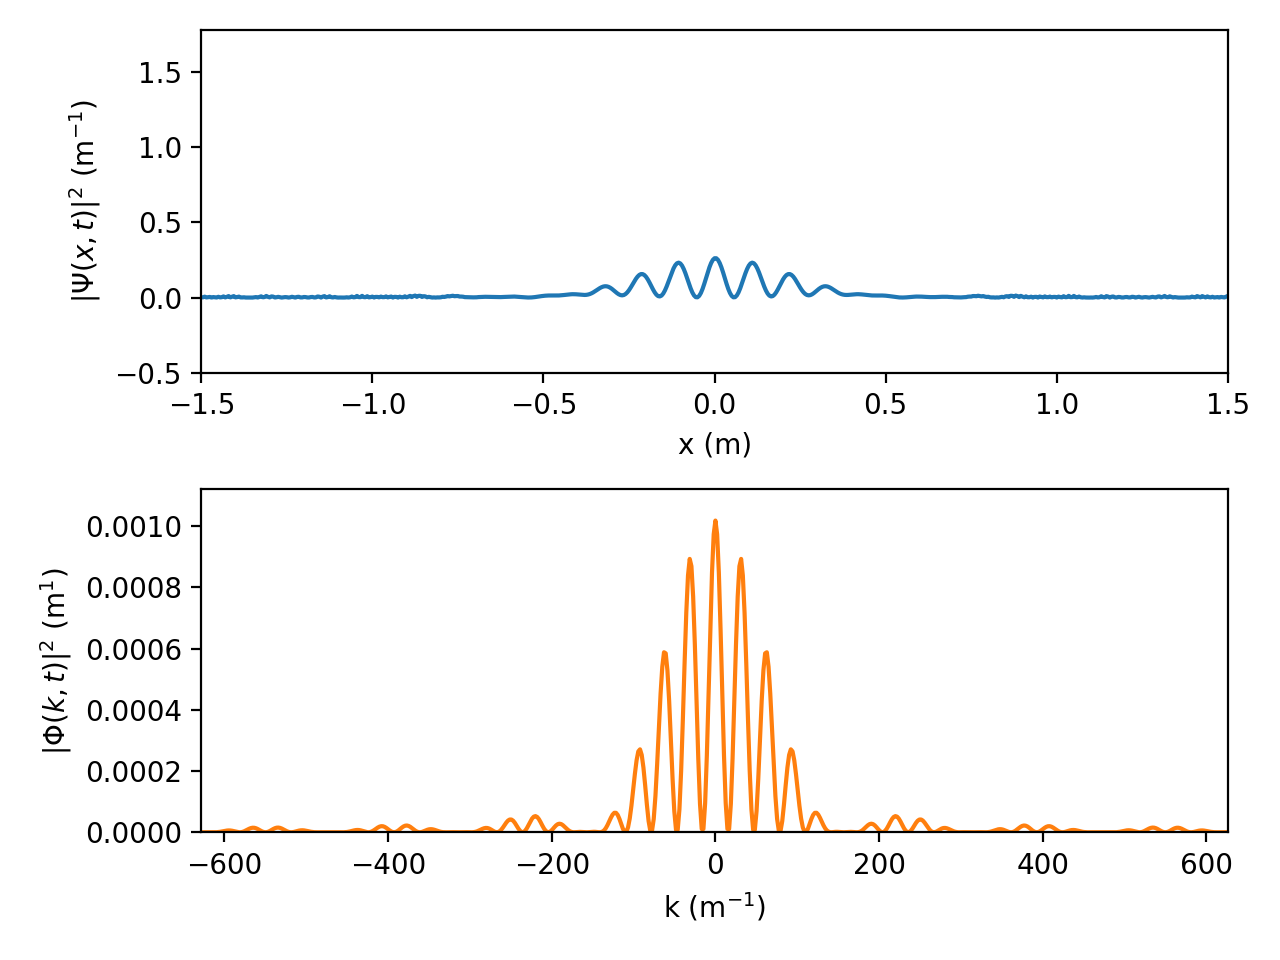

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1);
lines = []

ax[0].set_xlim(xrange)
ax[0].set_ylim([-.5, 1.1 * np.max(np.abs(psixt)**2)])
lines.append(ax[0].plot([], [], label='$|\Psi|^2$)')[0]);
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('$|\Psi(x, t)|^2$ (m$^{-1}$)')
ax[1].set_xlim([karr.min(), karr.max()])
ax[1].set_ylim([0, 1.1 * np.max(np.abs(psikt)**2)])
lines.append(ax[1].plot([], [], 'C1', label='$|\Phi|^2$)')[0]);
plt.xlabel('k (m$^{-1}$)')
plt.ylabel('$|\Phi(k, t)|^2$ (m$^{1}$)')
plt.tight_layout()
    
def init():
    for line in lines:
        line.set_data([], [])

def animate(i):
    lines[0].set_data(xarr, np.abs(psixt[i, :])**2)
    lines[1].set_data(karr, np.abs(psikt[i, :])**2)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(tarr), interval=100, blit=True)
# HTML(anim.to_html5_video())
# anim.save('im.mp4')